<a href="https://colab.research.google.com/github/Dinesh-Adhithya-H/Deep_Learning_using_Tensorflow/blob/main/C2_3_Cats_vs_Dogs_Classification_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  

--2021-02-06 12:56:10--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  64.2MB/s    in 1.3s    

2021-02-06 12:56:12 (64.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file="/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [4]:
pre_trained_model=InceptionV3(input_shape=(150,150,3),include_top=False,weights=None)

In [5]:
pre_trained_model.load_weights(local_weights_file)

In [6]:
for layer in pre_trained_model.layers:
  layer.trainable=False

In [7]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
last_layer=pre_trained_model.get_layer("mixed10")

In [9]:
print("last layer output shape",last_layer.output_shape)

last layer output shape (None, 3, 3, 2048)


In [10]:
last_output=last_layer.output

In [11]:
last_output

<KerasTensor: shape=(None, 3, 3, 2048) dtype=float32 (created by layer 'mixed10')>

In [12]:
from tensorflow.keras.optimizers import RMSprop
x=layers.Flatten()(last_output)
x=layers.Dense(1024,activation="relu")(x)
x=layers.Dropout(0.2)(x)
x=layers.Dense(1,activation="sigmoid")(x)

model=Model(pre_trained_model.input,x)

model.compile(optimizer=RMSprop(lr=0.0001),loss="binary_crossentropy",metrics=["accuracy"])

In [13]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2021-02-06 12:56:21--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c07::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   133MB/s    in 0.5s    

2021-02-06 12:56:21 (133 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [14]:
import zipfile
local_zip="/tmp/cats_and_dogs_filtered.zip"
zip=zipfile.ZipFile(local_zip,"r")
zip.extractall("/tmp")
zip.close()
base_dir="/tmp/cats_and_dogs_filtered"

train_dir=os.path.join(base_dir,"train")
validation_dir=os.path.join(base_dir,"validation")

train_dogs_dir=os.path.join(train_dir,"dogs")
train_cats_dir=os.path.join(train_dir,"cats")

validation_cats_dir=os.path.join(validation_dir,"cats")
validation_dogs_dir=os.path.join(validation_dir,"dogs")
train_cat_fnames=os.listdir(train_cats_dir)
train_dog_fnames=os.listdir(train_dogs_dir)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1.0/255.0,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode="nearest")
test_datagen=ImageDataGenerator(rescale=1.0/255.0)
train_generator=train_datagen.flow_from_directory(train_dir,batch_size=20,class_mode="binary",target_size=(150,150))
validation_generator=test_datagen.flow_from_directory(validation_dir,batch_size=20,class_mode="binary",target_size=(150,150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
history=model.fit(train_generator,validation_data=validation_generator,steps_per_epoch=100,epochs=15,validation_steps=50,verbose=2)

Epoch 1/15
100/100 - 29s - loss: 1.1684 - accuracy: 0.8490 - val_loss: 0.1657 - val_accuracy: 0.9540
Epoch 2/15
100/100 - 17s - loss: 0.4675 - accuracy: 0.8865 - val_loss: 0.2079 - val_accuracy: 0.9410
Epoch 3/15
100/100 - 17s - loss: 0.4009 - accuracy: 0.8980 - val_loss: 0.1249 - val_accuracy: 0.9650
Epoch 4/15
100/100 - 17s - loss: 0.3789 - accuracy: 0.9080 - val_loss: 0.1157 - val_accuracy: 0.9620
Epoch 5/15
100/100 - 17s - loss: 0.3232 - accuracy: 0.9205 - val_loss: 0.1197 - val_accuracy: 0.9630
Epoch 6/15
100/100 - 17s - loss: 0.3335 - accuracy: 0.9160 - val_loss: 0.3051 - val_accuracy: 0.9260
Epoch 7/15
100/100 - 17s - loss: 0.3019 - accuracy: 0.9250 - val_loss: 0.1714 - val_accuracy: 0.9520
Epoch 8/15
100/100 - 17s - loss: 0.2927 - accuracy: 0.9200 - val_loss: 0.1422 - val_accuracy: 0.9670
Epoch 9/15
100/100 - 17s - loss: 0.2500 - accuracy: 0.9310 - val_loss: 0.1466 - val_accuracy: 0.9620
Epoch 10/15
100/100 - 17s - loss: 0.2891 - accuracy: 0.9205 - val_loss: 0.2653 - val_accura

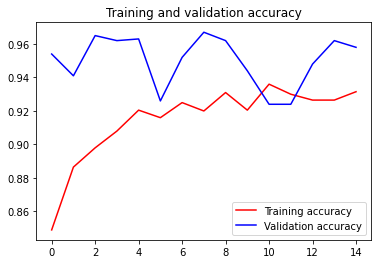

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()